# Draft: AuxTel Pointing

Ioana, you might jump Analyse The Telescope Pointing

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm

from astropy.table import Table, join

In [29]:
%matplotlib inline


## Develop Query Butler wcs

In [32]:
repo = '/repo/main/butler.yaml'
instrument = 'LATISS'
# collection = 'u/mfl/testProcessCcd'
collection = 'u/mfl/testProcessCcd_srcMatchFull_181e6356'

import lsst.rapid.analysis.butlerUtils as bu
butler = bu.makeDefaultLatissButler('NCSA', extraCollections=[collection])
registry=butler.registry

In [34]:
for dtype in registry.queryDatasetTypes():
    try:
        datasetRefs = list(registry.queryDatasets(datasetType=dtype,collections=collection))
        if len(datasetRefs)>0:
            print(len(datasetRefs), dtype )
    except:
        #print("Error", dtype )
        i=0

1475 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
1 DatasetType('camera', {instrument}, Camera, isCalibration=True)
51623 DatasetType('sdss_dr9_fink_v5b', {htm7}, SimpleCatalog)
130924 DatasetType('ps1_pv3_3pi_20170110', {htm7}, SimpleCatalog)
131072 DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog)
1421 DatasetType('srcMatchFull', {band, instrument, detector, physical_filter, visit_system, visit}, Catalog)
1459 DatasetType('icSrc', {band, instrument, detector, physical_filter, visit_system, visit}, SourceCatalog)
1421 DatasetType('sourceTable', {band, instrument, detector, physical_filter, visit_system, visit}, DataFrame)
1421 DatasetType('src', {band, instrument, detector, physical_filter, visit_system, visit}, SourceCatalog)
1421 DatasetType('source', {band, instrument, detector, physical_filter, visit_system, visit}, DataFrame)
1421 DatasetType('srcMatch', {band, instrument, detector, physical_filter, visit_system, visit}, Catalog)
142

In [179]:
dataset_refs = list(registry.queryDatasets('calexp', collections=collection))
dataset_refs = sorted(dataset_refs, key=lambda x : x.dataId['visit'])
print(len(dataset_refs))

1421


In [39]:
expIds = [int(ref.dataId['visit']) for ref in dataset_refs]

In [52]:
day_obs = int(str(expIds[0])[:8])
              
dataId = {"instrument": instrument, "exposure.day_obs": day_obs, "visit": expIds[0], "detector": 0}
wcsInfo = butler.get('calexp.wcs', dataId)

https://pipelines.lsst.io/py-api/lsst.afw.geom.SkyWcs.html#lsst.afw.geom.SkyWcs

In [74]:
type(wcsInfo)

lsst.afw.geom.SkyWcs

In [ ]:
wcsInfo

FITS standard SkyWcs:
Sky Origin: (144.7027925874, -60.0833961515)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095669 arcsec/pixel

In [106]:
# sp = wcsInfo.getSkyOrigin()
ra, dec = wcsInfo.getSkyOrigin().getRa().asDegrees(), wcsInfo.getSkyOrigin().getDec().asDegrees()

In [110]:
exp = butler.get('raw', dataId)

In [137]:
toto = butler.get('raw.metadata', dataId)

In [139]:
# toto.toDict()

In [117]:
exp.getMetadata().toDict()

{'SIMPLE': True,
 'EXTEND': True,
 'COMMENT': ["  FITS (Flexible Image Transport System) format is defined in 'Astronomy",
  "  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H",
  "  FITS (Flexible Image Transport System) format is defined in 'Astronomy",
  "  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H",
  '---- Date, night and basic image information ----',
  '---- Telescope info, location, observer ----',
  '---- Pointing info, etc. ----',
  '---- TAN Projection ----',
  '---- Image-identifying used to build OBS-ID ----',
  '---- Information from Camera ----',
  '---- Geometry from Camera ----',
  '---- Filter/grating information ----',
  '---- Exposure-related information ----',
  '---- Header information ----',
  '---- Checksums ----'],
 'ORIGIN': 'LSST DM Header Service',
 'TIMESYS': 'TAI',
 'DATE': '2020-02-18T04:08:12.684',
 'DATE-OBS': '2020-02-18T04:08:04.583',
 'DATE-BEG': '2020-02-18T04:08:04.583',
 'DATE-END': '2020-02-18T04:

In [121]:
mData = exp.getMetadata().toDict()

In [128]:
mylist = ['RA','DEC','MJD','EXPTIME','TEMP_SET','CCDTEMP','FILTER',
          'ELSTART','ELEND','AZSTART','AZEND','ELSTART']

In [131]:
myinfo = {k:mData[k] for k in mylist}
myinfo['RA_WCS'] = ra
myinfo['DEC_WCS'] = dec

myinfo

{'RA': 144.69658625,
 'DEC': -60.0918727777778,
 'MJD': 58897.1723690288,
 'EXPTIME': 5.0,
 'TEMP_SET': -104.150001525879,
 'CCDTEMP': -100.805046081543,
 'FILTER': 'empty_3',
 'ELSTART': 59.8590319438808,
 'ELEND': 59.8620842977398,
 'AZSTART': 173.810313124617,
 'AZEND': 173.842711527308,
 'RA_WCS': 144.70279258740916,
 'DEC_WCS': -60.083396151486355}

In [78]:
# print(wcsInfo.writeString())

In [85]:
# The array transformation function is not working

x = y = np.arange(0,10)
wcsInfo.pixelToSkyArray(x,x,degrees=True)

TypeError: applyForward(): incompatible function arguments. The following argument types are supported:
    1. (self: astshim.mapping.Mapping, from: numpy.ndarray) -> numpy.ndarray
    2. (self: astshim.mapping.Mapping, from: List[float]) -> List[float]

Invoked with: astshim.SeriesMap, array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

## Query Pointing Info

In [183]:
mylist = ['RA','DEC','MJD','EXPTIME','TEMP_SET','CCDTEMP','FILTER',
          'ELSTART','ELEND','AZSTART','AZEND','ELSTART']

def getSkyOriginValues(wcsInfo):
    ra = wcsInfo.getSkyOrigin().getRa().asDegrees()
    dec = wcsInfo.getSkyOrigin().getDec().asDegrees()
    return ra, dec

def query_wcs_pointing(dataId):
    wcsInfo = butler.get('calexp.wcs', dataId)
    ra, dec = getSkyOriginValues(wcsInfo)
    return ra, dec

def query_main_pointing_info(expId):
    day_obs = int(str(expId)[:8])
    dataId = {"instrument": instrument, "exposure.day_obs": day_obs, "visit": expId, "detector": 0}

    ra, dec = query_wcs_pointing(dataId)
    
    mData = butler.get('raw.metadata', dataId).toDict()
    myinfo = {k:mData[k] for k in mylist}
    myinfo['RA_WCS'] = ra
    myinfo['DEC_WCS'] = dec
    
    return myinfo

In [184]:
dataset_refs = list(registry.queryDatasets('calexp', collections=collection))
dataset_refs = sorted(dataset_refs, key=lambda x : x.dataId['visit'])
print(len(dataset_refs))

1421


In [185]:
expIds = [int(ref.dataId['visit']) for ref in dataset_refs]

In [198]:
%%capture

tables = []
for expId in expIds:
    print(f'exposure: {expId}')
    tables.append(query_main_pointing_info(expId))

In [199]:
tables[0]

{'RA': 144.69658625,
 'DEC': -60.0918727777778,
 'MJD': 58897.1723690288,
 'EXPTIME': 5.0,
 'TEMP_SET': -104.150001525879,
 'CCDTEMP': -100.805046081543,
 'FILTER': 'empty_3',
 'ELSTART': 59.8590319438808,
 'ELEND': 59.8620842977398,
 'AZSTART': 173.810313124617,
 'AZEND': 173.842711527308,
 'RA_WCS': 144.70279258740916,
 'DEC_WCS': -60.083396151486355}

In [200]:
import pandas as pd
df = pd.DataFrame(tables)
df

,RA,DEC,MJD,EXPTIME,TEMP_SET,CCDTEMP,FILTER,ELSTART,ELEND,AZSTART,AZEND,RA_WCS,DEC_WCS
0,144.696586,-60.091873,58897.172369,5.0,-104.150002,-100.805046,empty_3,59.859032,59.862084,173.810313,173.842712,144.702793,-60.083396
1,307.078084,-87.472205,58899.053545,5.0,-104.150002,-100.776344,RG610,28.093086,28.092282,181.448881,181.447321,306.948404,-87.469098
2,307.078084,-87.472205,58899.053854,5.0,-104.150002,-100.766220,RG610,28.090576,28.089861,181.443863,181.442496,306.948123,-87.468959
3,307.078084,-87.472205,58899.054891,2.0,-104.150002,-100.795662,empty_1,28.076867,28.076392,181.429553,181.428578,306.945464,-87.463069
4,307.078084,-87.472205,58899.056000,2.0,-104.150002,-100.791946,empty_1,28.072545,28.072041,181.422354,181.421200,307.178286,-87.462851
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,162.767734,-48.503156,59523.326981,15.0,-94.150002,-90.320419,FELH0600,34.140412,34.189538,130.793951,130.784860,162.770156,-48.504776
1417,162.767734,-48.503156,59523.327185,15.0,-94.150002,-90.328224,FELH0600,34.189538,32.238604,130.784860,130.757985,162.770099,-48.504759
1418,102.086582,-43.056208,59523.332988,5.0,-94.150002,-90.324783,FELH0600,75.573488,75.585827,154.703962,154.788120,102.082373,-43.048047
1419,102.086582,-43.056208,59523.338070,5.0,-94.150002,-90.336678,FELH0600,76.174799,76.184880,159.616764,159.709761,102.075312,-43.067226


In [201]:
from datetime import date

today = date.today()

# dd/mm/YY
d1 = today.strftime("%d%m%Y")
print("d1 =", d1)

d1 = 23032022


In [202]:
df.to_csv(f'checking_auxtel_pointing_{d1}.csv')
# df.to_csv('checking_auxtel_pointing.csv')

# Analyse The Telescope Pointing

In [36]:
import pandas as pd
date = 23032022
df = pd.read_csv(f'data/checking_auxtel_pointing_{date}.csv')

In [ ]:
import numpy as np

deg = np.pi/180.
def separation(ra1,dec1,ra2,dec2):
    return np.sqrt( np.cos(dec1*deg)*(ra1-ra2)**2 + (dec1-dec2)**2 )*3600.

def getAngDist(ra1, dec1, ra2, dec2):
    # output in arcmin
    delt_lon = (ra1 - ra2)*np.pi/180.
    delt_lat = (dec1 - dec2)*np.pi/180.
    # Haversine formula
    dist = 2.0*np.arcsin( np.sqrt( np.sin(delt_lat/2.0)**2 + \
         np.cos(dec1*np.pi/180.)*np.cos(dec2*np.pi/180.)*np.sin(delt_lon/2.0)**2 ) )  
    return (dist/np.pi*180.)*60

In [18]:
df['offset'] = getAngDist(df['RA_WCS'], df['DEC_WCS'], df['RA'], df['DEC'])
df['dRA'] = (df['RA_WCS']-df['RA'])*60
df['dDEC']= (df['DEC_WCS']-df['DEC'])*60

In [19]:
df['AZMEAN'] = 0.5*(df['AZEND']+df['AZSTART'])

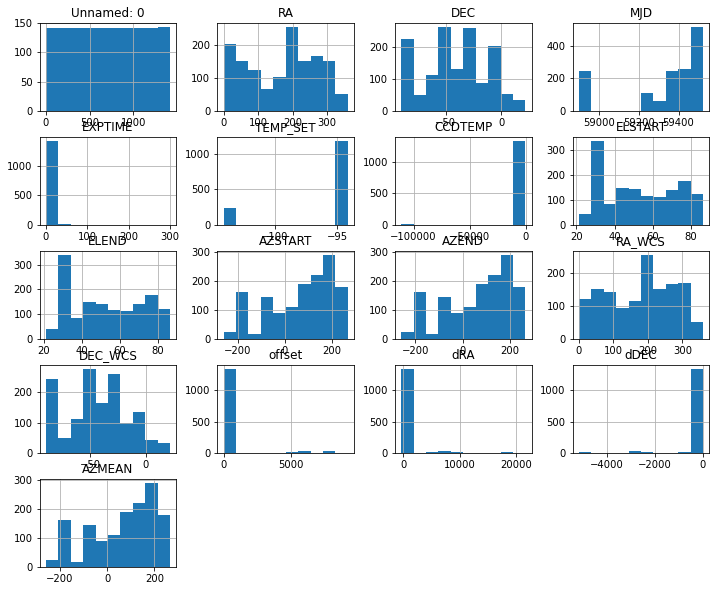

In [20]:
_ = df.hist(figsize=(12,10))